## Week 5: Knowledge Distillation Lab

Welcome to this lab! We will talk about Knowledge Distillation (KD) in NLP!

**The objectives of this lab are as follows**:

1. Make you guys understand better about KD! Feel free to ask and discuss. We are here to learn more!
2. You get the general idea of this topic? Well, you need to exercise to have a better understanding! By the end, you know the basic idea of how to implement KD using your own hand!

## Tools

Here, we use these libraries to implement the learning algorithm:
1. `pytorch`
2. `transformers`: used to download a pre-trained model
3. `lightning`: used to make training easier and no boilerplate in pytorch
4. `datasets`: used to load data uploaded from `huggingface`
5. `safetensors`: save or load tensors

## Motivation (Refresher)

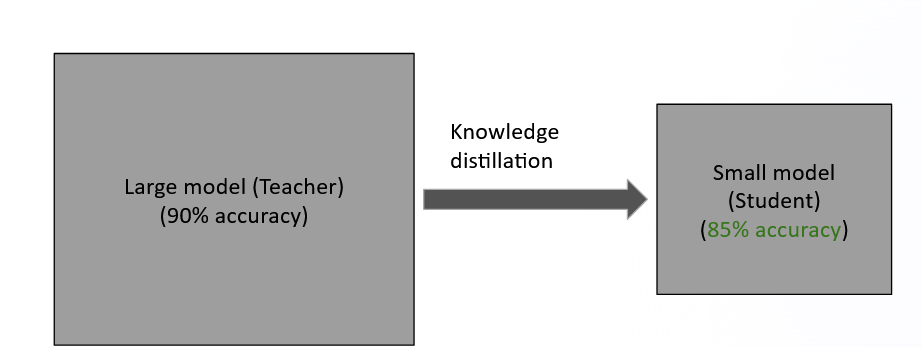

- With Knowledge Distillation you can produce a lightweight model which has small drop in performance to the bigger model.
- Faster inference that address cost, accessibility, and privacy issues

### Basic idea

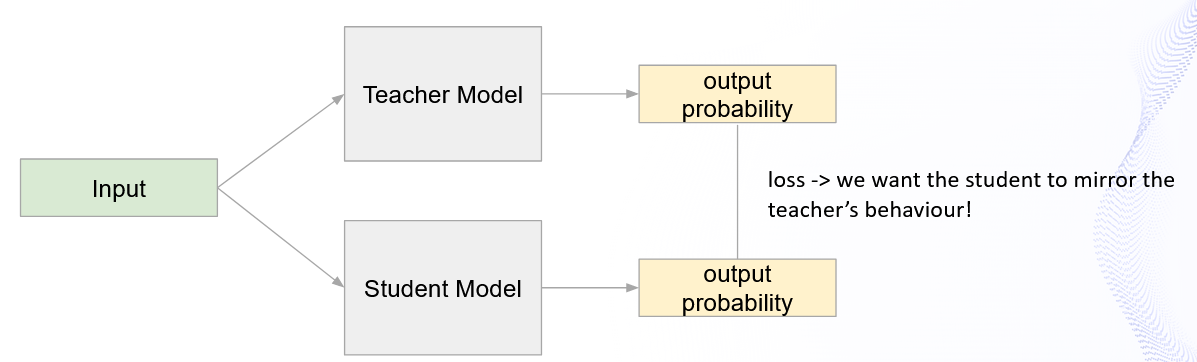

We try to make the output distribution of a student SIMILAR to its teacher's performance.

We do this by computing the distance between the student and the student's output(s) and MINIMIZE IT!

Several distance metrics:

1. **MSE (input: logits)**  (We use this)
2. KL-Divergence (input: probability)



# LET'S GO!

<div style="width:360px;max-width:100%;"><div style="height:0;padding-bottom:67.5%;position:relative;"><iframe width="360" height="243" style="position:absolute;top:0;left:0;width:100%;height:100%;" frameBorder="0" src="https://imgflip.com/embed/8escec"></iframe></div></div>

## Plan

We will do distillation in Encoder Model

Data: **tweet-eval sentiment**

Teacher model: **BERT-base**

Student model: **Smaller BERT**

### Benchmark

1. Teacher model Accuracy
2. Student model Accuracy (without KD)
3. Student model Accuracy (with KD)


## Let's implement it

In [ ]:
# If you haven't installed the libraries yet, you can do so by running the following command
# !pip install datasets transformers lightning

In [1]:
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar
from transformers import AutoTokenizer, DataCollatorWithPadding
from torchmetrics import F1Score
from torch import nn
import torch
from torch.utils.data import DataLoader
from copy import deepcopy
from lightning import Trainer, seed_everything
from tqdm import tqdm
from safetensors.torch import save, save_file, load_file

Reproducibility

In [2]:
seed_everything(42)

Seed set to 42


42

We just load it normally using `datasets`

In [3]:
dataset = load_dataset("tweet_eval", "sentiment")

In [66]:
num_label = len(set(dataset['train']['label']))


In [4]:
model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

In [7]:
data_train = dataset['train']
data_dev = dataset['validation']
data_test = dataset['test']

In [8]:
def tokenize(x, tokenizer):
    return tokenizer(x['text'])

In [9]:
data_train = data_train.map(lambda x: tokenize(x, tokenizer_bert), batched=True, remove_columns=["text"])
data_dev = data_dev.map(lambda x: tokenize(x, tokenizer_bert), batched=True, remove_columns=["text"])
data_test = data_test.map(lambda x: tokenize(x, tokenizer_bert), batched=True, remove_columns=["text"])


## Define the finetune class

In [11]:
class FTModel(L.LightningModule):

    def __init__(self, model, lr: float, num_label: int = 6):
        super().__init__()
        self.model = model
        self.lr = lr
        self.ce_loss = nn.CrossEntropyLoss()

        # EVALUATION METRICS
        self.train_f1 = F1Score('multiclass', num_classes=num_label, average='micro')
        self.val_f1 = F1Score('multiclass', num_classes=num_label, average='micro')
        self.test_f1 = F1Score('multiclass', num_classes=num_label, average='micro')

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        y = batch.pop('labels')
        y_hat = self(**batch).logits
        loss = self.ce_loss(y_hat,y)
        self.train_f1(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    @classmethod
    def load_from_hf(cls, model_name: str, lr: float):
        """
        Load a model from the Hugging Face Hub and set the learning rate.

        Parameters
        ----------
        model_name : str
            The model name to load from the Hugging Face Hub.
        lr : float
            The learning rate to use for training.

        Returns
        -------
        _LightningModule
            A model instance.
        """
        hf_model = AutoModelForSequenceClassification.from_pretrained(model_name)
        return cls(hf_model, lr, hf_model.num_labels)
        
    def validation_step(self, batch, batch_idx):
        y = batch.pop('labels')
        y_hat = self(**batch).logits
        loss = self.ce_loss(y_hat,y)
        self.val_f1(y_hat, y)
        self.log("f1_val_step", self.val_f1, on_epoch=True, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        y = batch.pop('labels')
        y_hat = self(**batch).logits
        loss = self.ce_loss(y_hat,y)
        self.test_f1(y_hat, y)
        self.log("f1_test_step", self.test_f1, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

In [12]:
lit_teacher_model = FTModel(model_bert, lr=1e-5, num_label=num_label)

In [13]:
train_dl = DataLoader(data_train, batch_size=64, collate_fn=DataCollatorWithPadding(tokenizer=tokenizer_bert), shuffle=True)
dev_dl = DataLoader(data_dev, batch_size=64,  collate_fn=DataCollatorWithPadding(tokenizer=tokenizer_bert))
test_dl = DataLoader(data_test, 64, collate_fn=DataCollatorWithPadding(tokenizer=tokenizer_bert))

Check first!


In [14]:
batch = next(iter(train_dl))
batch.pop('labels')
lit_teacher_model(**batch)


SequenceClassifierOutput(loss=None, logits=tensor([[ 0.2132,  0.2604, -0.1122],
        [ 0.2760,  0.4975, -0.1451],
        [ 0.2186,  0.3692, -0.1185],
        [ 0.3908,  0.4687, -0.1924],
        [ 0.1691,  0.4750, -0.2070],
        [ 0.2441,  0.4315, -0.2220],
        [ 0.3800,  0.5155, -0.2682],
        [ 0.2483,  0.4668, -0.1349],
        [ 0.2941,  0.5480, -0.2852],
        [ 0.3554,  0.3697, -0.0441],
        [ 0.2419,  0.5256, -0.1549],
        [ 0.3297,  0.3739, -0.1920],
        [-0.0270,  0.0615, -0.0704],
        [ 0.2867,  0.2608, -0.2178],
        [ 0.3249,  0.4839, -0.1830],
        [ 0.2844,  0.4199, -0.2533],
        [ 0.1686,  0.2533, -0.0997],
        [ 0.2601,  0.3123, -0.1413],
        [ 0.3882,  0.5146, -0.1624],
        [ 0.3625,  0.3977, -0.1849],
        [ 0.2238,  0.4790, -0.2079],
        [ 0.2867,  0.4248, -0.2523],
        [ 0.0989,  0.1624, -0.0145],
        [ 0.3002,  0.3737, -0.1904],
        [ 0.2199,  0.3089, -0.1033],
        [ 0.3867,  0.3067,  0.01

Initialize the Trainer

In [16]:
# Provide the callback
checkpoint_callback = ModelCheckpoint(dirpath="outputs/teacher/",
                                      filename='{epoch}-{val_loss:.2f}-{f1_val_step:.2f}',
                                      save_top_k=1,
                                      monitor="f1_val_step", mode="max")
ea_stop = EarlyStopping(patience=5, monitor="f1_val_step", mode="max")
rich = RichProgressBar()

In [18]:
trainer = Trainer(max_epochs=50, callbacks=[checkpoint_callback, rich, ea_stop], accelerator="gpu", devices=1, precision="16-mixed", val_check_interval=300, check_val_every_n_epoch=None)

trainer.fit(lit_teacher_model, train_dl, dev_dl)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model    │ BertForSequenceClassification │  109 M │
│ 1 │ ce_loss  │ CrossEntropyLoss              │      0 │
│ 2 │ train_f1 │ MulticlassF1Score             │      0 │
│ 3 │ val_f1   │ MulticlassF1Score             │      0 │
│ 4 │ test_f1  │ MulticlassF1Score             │      0 │
└───┴──────────┴───────────────────────────────┴────────┘

Trainable params: 109 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 109 M                                                                                                
Total estimated model params size (MB): 437

Output()

In [22]:
lit_teacher_model = FTModel.load_from_checkpoint(checkpoint_callback.best_model_path, model=model_bert, lr=None, num_label=num_label)

I don't think we're going to wait the training process... Let's just download the model that I have prepared.

In [23]:
lit_teacher_model = FTModel.load_from_hf("haryoaw/nlp702-w5-teacher", lr=0.001)
# lit_teacher_model = FTModel.load_from_checkpoint("outputs/teacher/epoch=1-val_loss=0.60-f1_val_step=0.74.ckpt", model=model_bert, lr=None, num_label=num_label)

We check the performance

In [24]:
trainer = Trainer(accelerator="gpu", devices=1, precision="16-mixed")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
trainer.test(lit_teacher_model, test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       f1_test_step        │    0.7114946246147156     │
└───────────────────────────┴───────────────────────────┘

[{'f1_test_step': 0.7114946246147156}]

## Upload the model to HF

In [ ]:
# This is how we do it
# lit_teacher_model.model.push_to_hub("nlp702-w5-teacher")

## Lets precompute to save time

In [30]:
train_dl_for_out = DataLoader(data_train, 
                              batch_size=64, 
                              collate_fn=DataCollatorWithPadding(tokenizer=tokenizer_bert), 
                              shuffle=False)

In [31]:
lit_teacher_model.eval()
lit_teacher_model = lit_teacher_model.cuda()
out_aggregated = []
with torch.no_grad():
    for x in tqdm(train_dl_for_out):
        out = lit_teacher_model(**x.to("cuda"))
        out_aggregated.append(out.logits.cpu().detach())
out_aggregated = torch.cat(out_aggregated)


100%|██████████| 713/713 [00:46<00:00, 15.22it/s]


In [32]:
save_file({'proba': out_aggregated}, "outputs/teacher/teacher_logits.safetensors")

# to load it
# load_file("outputs/teacher/teacher_logits.safetensors")

## Let's train a small model from scratch as a baseline

Let's half the num layers and set its attention heads to 1.

In [33]:
model_smol_cfg = deepcopy(model_bert.config)
model_smol_cfg.num_hidden_layers = 6
model_smol_cfg.num_attention_heads = 1
small_scratch_model = AutoModelForSequenceClassification.from_config(model_smol_cfg)

In [61]:
lit_small_model = FTModel(small_scratch_model, 1e-5, num_label=num_label)

In [62]:
checkpoint_callback = ModelCheckpoint(dirpath="outputs/small_scratch/",
                                      filename='{epoch}-{val_loss:.2f}-{f1_val_step:.2f}',
                                      save_top_k=1,
                                      monitor="f1_val_step", mode="max")
ea_stop = EarlyStopping(patience=5, monitor="f1_val_step", mode="max")
rich = RichProgressBar()
trainer = Trainer(max_epochs=50, callbacks=[checkpoint_callback, rich, ea_stop],accelerator='gpu', 
                  devices=1, precision="16-mixed", val_check_interval=300, check_val_every_n_epoch=None)
trainer.fit(lit_small_model, train_dl, dev_dl)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model    │ BertForSequenceClassification │ 67.0 M │
│ 1 │ ce_loss  │ CrossEntropyLoss              │      0 │
│ 2 │ train_f1 │ MulticlassF1Score             │      0 │
│ 3 │ val_f1   │ MulticlassF1Score             │      0 │
│ 4 │ test_f1  │ MulticlassF1Score             │      0 │
└───┴──────────┴───────────────────────────────┴────────┘

Trainable params: 67.0 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 67.0 M                                                                                               
Total estimated model params size (MB): 267

Output()

In [36]:
# If you load from best checkpoint: checkpoint_callback.best_model_path

In [39]:
lit_small_model = FTModel.load_from_checkpoint(checkpoint_callback.best_model_path, model=small_scratch_model, num_label=num_label, lr=None)
trainer = Trainer(max_epochs=10, callbacks=[checkpoint_callback],accelerator='gpu', devices=1)
trainer.test(lit_small_model, test_dl)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       f1_test_step        │    0.5957342982292175     │
└───────────────────────────┴───────────────────────────┘

[{'f1_test_step': 0.5957342982292175}]

## Knowledge Distillation

Finally, Let's create a KD class. Let's do it together

In [40]:
class KDModel(L.LightningModule):

    def __init__(self):
        super().__init__()
        
    def forward(self, *args, **kwargs):
        # Forward

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.

    def validation_step(self, batch, batch_idx):
        # implement your validation step here

    def test_step(self, batch, batch_idx):
        # implement your test step here`

    def configure_optimizers(self):
        # optimizer

In [41]:
model_smol_cfg = deepcopy(model_bert.config)
model_smol_cfg.num_hidden_layers = 6
model_smol_cfg.num_attention_heads = 1
small_scratch_model = AutoModelForSequenceClassification.from_config(model_smol_cfg)

In [49]:
trainer.test(kd_model, test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       f1_test_step        │    0.6201626658439636     │
└───────────────────────────┴───────────────────────────┘

[{'f1_test_step': 0.6201626658439636}]

## How to do feature-based distillation?

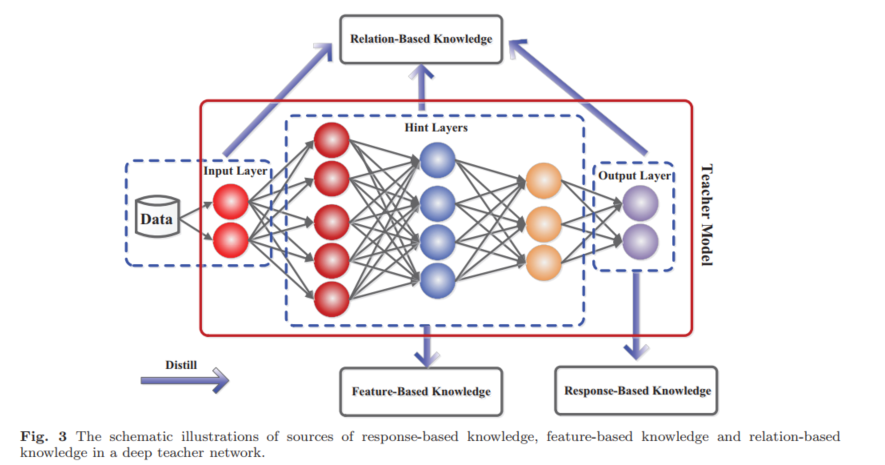 [1]

Let us focus on distilling the output of each hidden layer.

Map each layer alternatively, i.e.: 
- teacher layer 2 -> student layer 1
- teacher layer 4 -> student layer 2, .... 
- teacher layer 12 -> student layer 6



In [79]:
# Now do this as your practice.
# We will do it together afterwards

class KDModelAfterUpdate(L.LightningModule):
    # PASS


In [91]:
trainer = Trainer()
trainer.test(kd_model_feature, test_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       f1_test_step        │    0.6033214330673218     │
└───────────────────────────┴───────────────────────────┘

[{'f1_test_step': 0.6033214330673218}]

## That's all!!

Hope you enjoy this lab session and understand better about KD! Have fun learning, and have a great day⭐!

The full code will be uploaded in the future.


## References

[1] Gou, Jianping, Baosheng Yu, Stephen John Maybank, and Dacheng Tao. “Knowledge Distillation: A Survey.” International Journal of Computer Vision 129, no. 6 (June 2021): 1789–1819.
